Current competition metric implies segmenation task. However one valid approach could incorporate object detection. In this direction, and borrowing content from an available kernel [https://www.kaggle.com/kmader/baseline-u-net-model-part-1](http://), we attempt to extract bounding boxes information from binary rle-encoded masks.

In [1]:
! pip install opencv-python

    100% |████████████████████████████████| 25.4MB 2.1MB/s eta 0:00:01
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
! pip install tqdm

    100% |████████████████████████████████| 51kB 30.1MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import os
import cv2
from tqdm import tqdm_notebook
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.util.montage import montage2d as montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
# ship_dir = '../input'
ship_dir = ''
train_image_dir = 'train'
test_image_dir = 'test'

from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list, all_masks=None):
    # Take the individual ship masks and create a single mask array for all ships
    if all_masks is None:
        all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

Let us read the masks:

In [5]:
masks = pd.read_csv('train_ship_segmentations_v2.csv')
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

231723 masks found
192556


ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

and keep only those that contain ships. Keep in mind that image files can be repeated many times in the csv file. So a unique operator will give us the unique filenames that contain ships.

In [6]:
images_with_ship = masks.ImageId[masks.EncodedPixels.isnull()==False]
images_with_ship = np.unique(images_with_ship.values)
print('There are ' +str(len(images_with_ship)) + ' image files with masks')

There are 42556 image files with masks


Create a method to read image data frm the S3 bucket. OpenCV did not work.

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import boto3
import io

def get_S3_image(image_name):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket('object-detection-airbus-dataset')
    image_object = bucket.Object(image_name)

    image = mpimg.imread(io.BytesIO(image_object.get()['Body'].read()), 'jpg')
    return image

In order to extract the bounding box we:
1. Load mask as binary numpy array using Kevin's `masks_as_image`)

2. Label  connected regions of this mask using `skimage.measure.label`

3. Measure morphological properties of these connected regions and keep the bounding box (`skimage.measure.regionprops`). For each connected region a bounding box of the form  (min_row, min_col, max_row, max_col) is returned.  

(*Note: Ships masks touching each other would be considered as one. See Image 00021ddc3.jpg below. This may hurt detection performance but we can find ways to further split them !* )

Let us view some  examples:

Image 000155de5.jpg
Found bbox (465, 344, 501, 448)


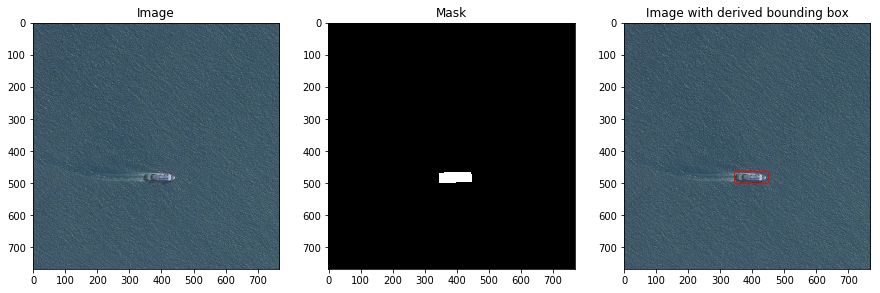

Image 000194a2d.jpg
Found bbox (377, 67, 387, 85)
Found bbox (174, 258, 185, 306)
Found bbox (178, 331, 197, 370)
Found bbox (287, 469, 307, 492)


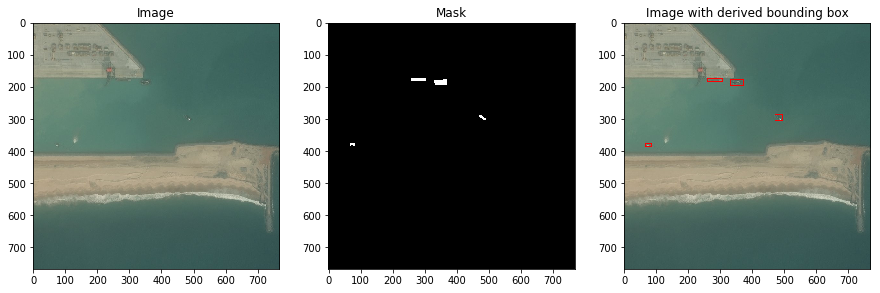

Image 00021ddc3.jpg
Found bbox (705, 96, 720, 121)
Found bbox (732, 123, 768, 178)
Found bbox (629, 181, 638, 187)
Found bbox (661, 195, 665, 201)


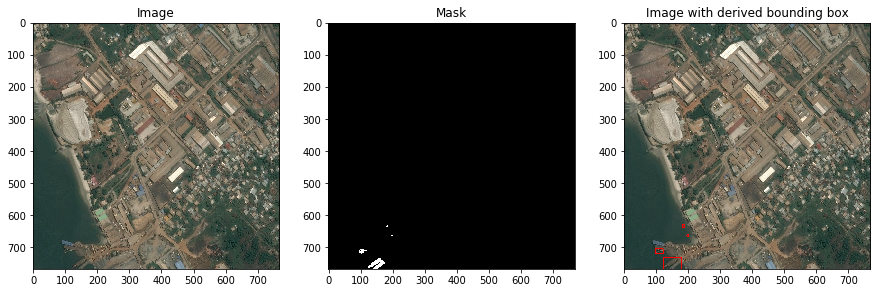

Image 0002756f7.jpg
Found bbox (36, 324, 67, 351)


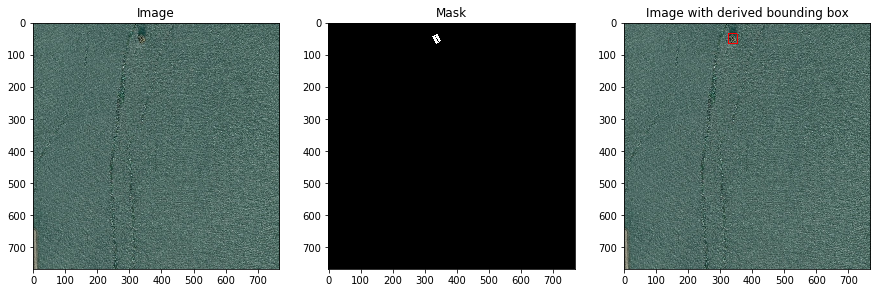

Image 00031f145.jpg
Found bbox (124, 443, 153, 472)


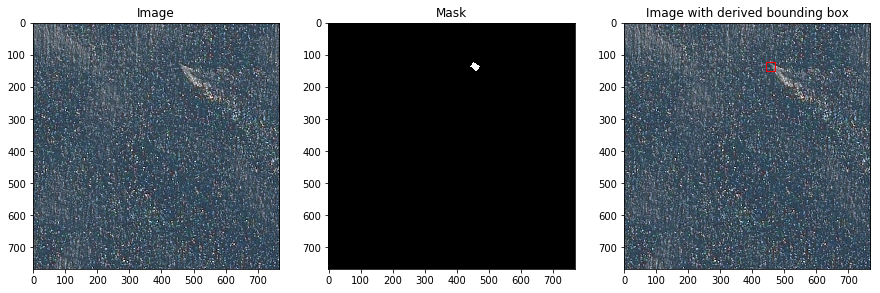

Image 000532683.jpg
Found bbox (460, 597, 474, 604)
Found bbox (756, 738, 763, 747)


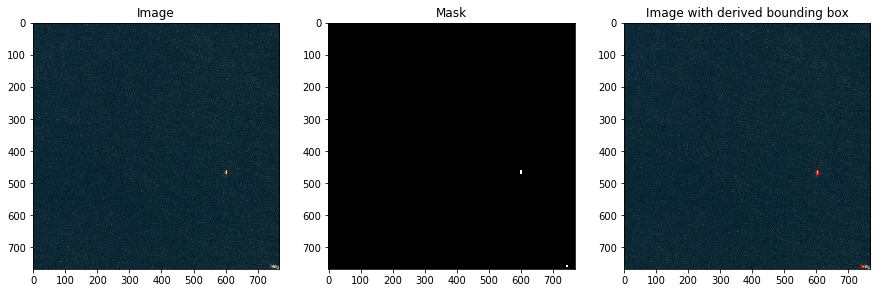

Image 00053c6ba.jpg
Found bbox (124, 736, 139, 752)


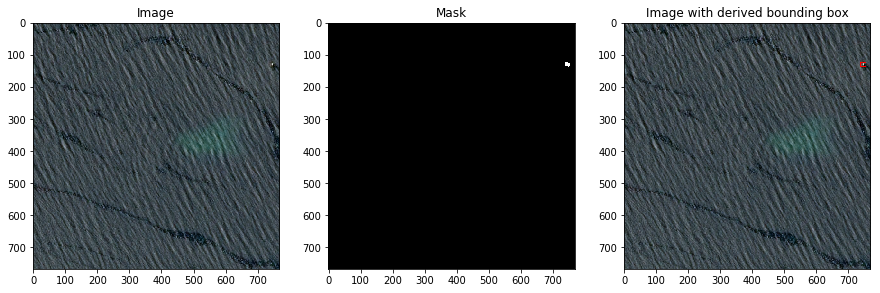

Image 0005d01c8.jpg
Found bbox (598, 72, 739, 237)
Found bbox (252, 476, 321, 556)


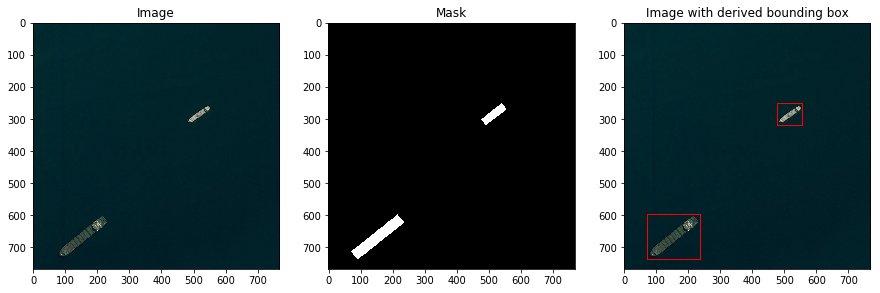

Image 0005d6d95.jpg
Found bbox (171, 345, 190, 367)


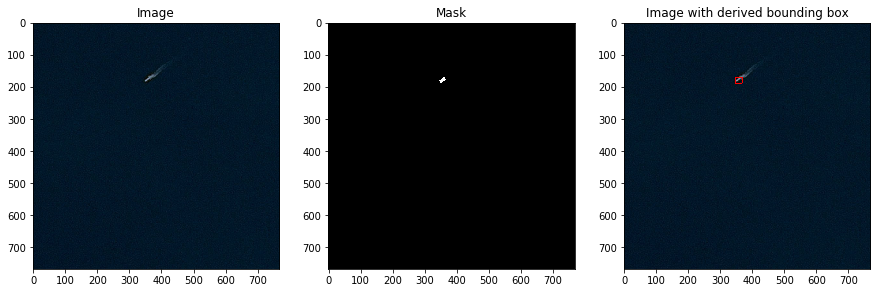

Image 0006c52e8.jpg
Found bbox (197, 190, 472, 407)


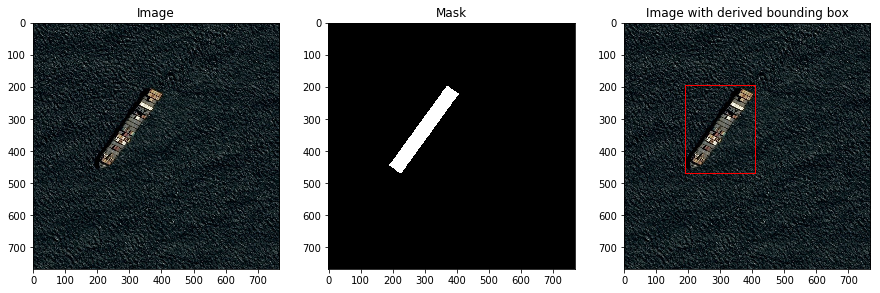

In [8]:
for i in range(10):
    image = images_with_ship[i]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
    img_0 = get_S3_image(train_image_dir+'/' + image)
    rle_0 = masks.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0)
    #
    # 
    lbl_0 = label(mask_0) 
    props = regionprops(lbl_0)
    img_1 = img_0.copy()
    print ('Image', image)
    for prop in props:
        print('Found bbox', prop.bbox)
        cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)


    ax1.imshow(img_0)
    ax1.set_title('Image')
    ax2.set_title('Mask')
    ax3.set_title('Image with derived bounding box')
    ax2.imshow(mask_0[...,0], cmap='gray')
    ax3.imshow(img_1)
    plt.show()

Here we calculate the bounding boxes for all `29070` images and save then into a dictionary. 

### Prepare Dataset

In [ ]:
import gc
import json

i = 0
count_ships = 0
for image in tqdm_notebook(images_with_ship):

    img_0 = get_S3_image(train_image_dir+'/' + image)
    rle_0 = masks.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0)

    lbl_0 = label(mask_0) 
    props = regionprops(lbl_0)

    jsonFile = image
    jsonFile = jsonFile.split('.')[0]+'.json'

    line = {}
    line['file'] = image
    line['image_size'] = [{
        'width':768,
        'height':768,
        'depth':3
    }]
    line['annotations'] = []
    line['categories'] = []

    for prop in props:
        line['annotations'].append({
            'class_id': 0,
            'top': prop.bbox[0],
            'left': prop.bbox[1],
            'width': prop.bbox[3]-prop.bbox[1],
            'height': prop.bbox[2]-prop.bbox[0]
        })
        line['categories'].append({
            'class_id': 0,
            'name': 'ship',
        })
    with open(os.path.join('generated', jsonFile),'w') as p:
        json.dump(line,p)

Let us plot some bounding boxes right from the dictionary we just created. 

In [58]:
image = '997663356.jpg'
jsonFile = 'generated/'+image.split('.')[0]+'.json'
with open(jsonFile, 'r') as f:
    js = json.load(f)

In [61]:
for annotation in js['annotations']:
    print(annotation)

{'class_id': 0, 'top': 443, 'left': 542, 'width': 23, 'height': 33}
{'class_id': 0, 'top': 599, 'left': 651, 'width': 14, 'height': 31}


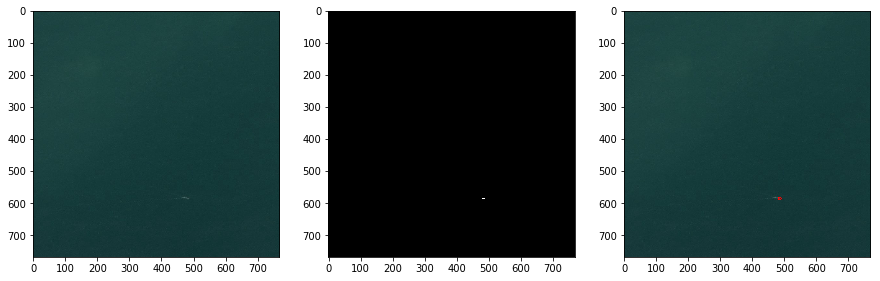

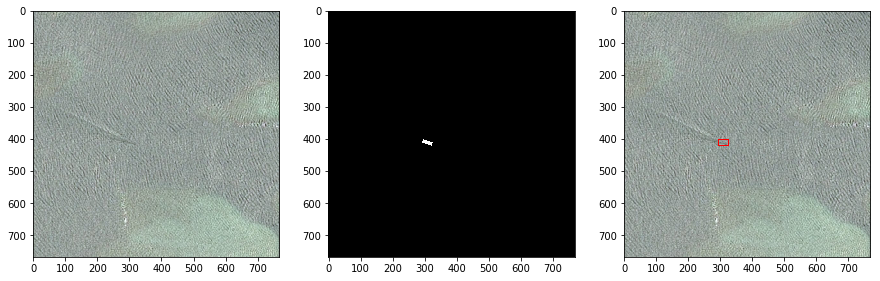

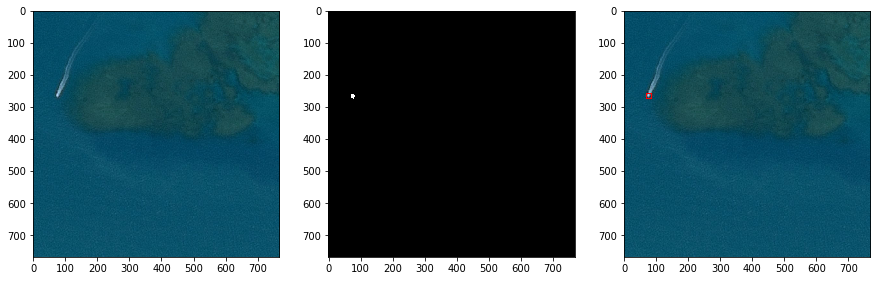

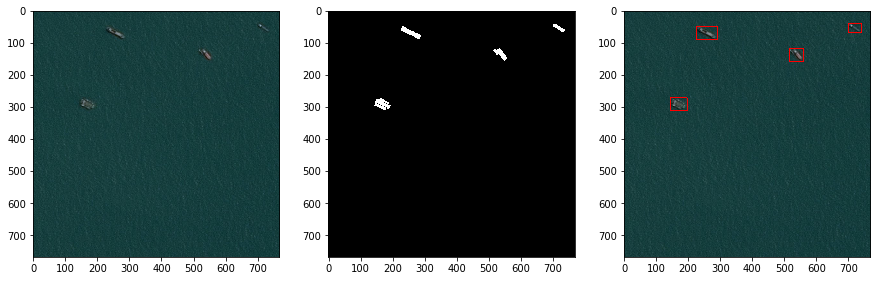

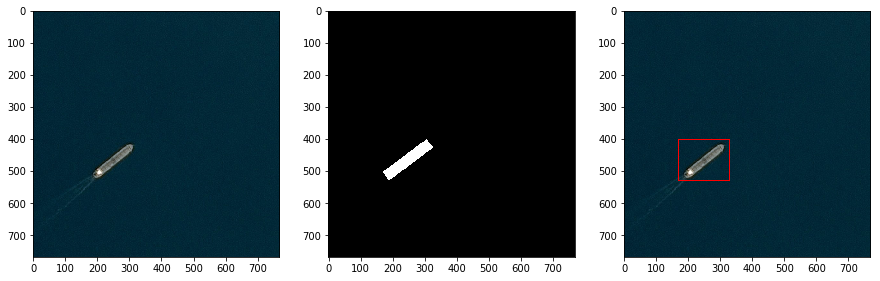

In [76]:
dict_images = list(bboxes_dict.keys())
for i in range(5):
    image = dict_images[10+i]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
    img_0 = get_S3_image(train_image_dir+'/' + image)
    rle_0 = masks.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0)
    img_1 = img_0.copy()
    
    jsonFile = 'generated/'+image.split('.')[0]+'.json'
    with open(jsonFile, 'r') as f:
        js = json.load(f)
    
    
    
    for annotation in js['annotations']:
        top = annotation['top']
        left = annotation['left']
        bottom = top+annotation['height']
        right = left+annotation['width']

        cv2.rectangle(img_1, (left, top), (right, bottom), (255, 0, 0), 2)


    ax1.imshow(img_0)
    ax2.imshow(mask_0[...,0], cmap='gray')
    ax3.imshow(img_1)
    plt.show()

In [77]:
import os
jsons = os.listdir('generated')

print ('There are {} images have annotation files'.format(len(jsons)))

There are 42556 images have annotation files


In [83]:
from sklearn.model_selection import train_test_split

train_jsons, test_jsons = train_test_split(jsons, test_size=0.25, random_state=1)

In [99]:
import shutil

#Moving training files to the training folders
print("Moving train files")
for i in tqdm_notebook(train_jsons):
    image_file = './train/'+i.split('.')[0]+'.jpg'
    shutil.move(image_file, './train_images/')
    shutil.move('./generated/'+i, './train_annotation/')

Moving train files


In [101]:
#Moving validation files to the validation folders
print("Moving validation files")
for i in tqdm_notebook(test_jsons):
    image_file = './train/'+i.split('.')[0]+'.jpg'
    shutil.move(image_file, './validation_images/')
    shutil.move('./generated/'+i, './validation_annotation/')

Moving validation files


### Setup

In [2]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::023375022819:role/service-role/AmazonSageMaker-ExecutionRole-20181029T121824
CPU times: user 425 ms, sys: 39.5 ms, total: 465 ms
Wall time: 489 ms


In [3]:
bucket = 'object-detection-airbus-dataset'

In [4]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection')
print(training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:1


### Upload to S3

In [15]:
%%time

train_channel = 'train'
validation_channel = 'validation'
train_annotation_channel = 'train_annotation'
validation_annotation_channel = 'validation_annotation'

# sess.upload_data(path='train', bucket=bucket, key_prefix=train_channel, )
# sess.upload_data(path='validation', bucket=bucket, key_prefix=validation_channel)
# sess.upload_data(path='train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
# sess.upload_data(path='validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 7.87 µs


In [25]:
s3_output_location = 's3://{}/output'.format(bucket)

### Training

In [28]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [29]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=80,
                             mini_batch_size=16,
                             epochs=30,
                             learning_rate=0.001,
                             lr_scheduler_step='10',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=512,
                             label_width=600,
                             num_training_samples=4452)

In [30]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

In [ ]:
od_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: object-detection-2019-03-13-21-42-16-154


2019-03-13 21:42:16 Starting - Starting the training job...
2019-03-13 21:42:18 Starting - Launching requested ML instances......
2019-03-13 21:43:29 Starting - Preparing the instances for training...
2019-03-13 21:44:15 Downloading - Downloading input data...........................................................................................

### Hosting

In [46]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: object-detection-2019-03-14-14-23-42-826
INFO:sagemaker:Creating endpoint with name object-detection-2019-03-13-21-42-16-154


---------------------------------------------------------------------------------------!

### Inference

In [33]:
!wget -O test.jpg https://images.pexels.com/photos/980382/pexels-photo-980382.jpeg
file_name = 'test.jpg'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

--2019-03-14 14:18:12--  https://images.pexels.com/photos/980382/pexels-photo-980382.jpeg
Resolving images.pexels.com (images.pexels.com)... 104.17.208.102, 104.17.209.102, 2606:4700::6811:d066, ...
Connecting to images.pexels.com (images.pexels.com)|104.17.208.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1836911 (1.8M) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]   1.75M  --.-KB/s    in 0.02s   

2019-03-14 14:18:12 (101 MB/s) - ‘test.jpg’ saved [1836911/1836911]



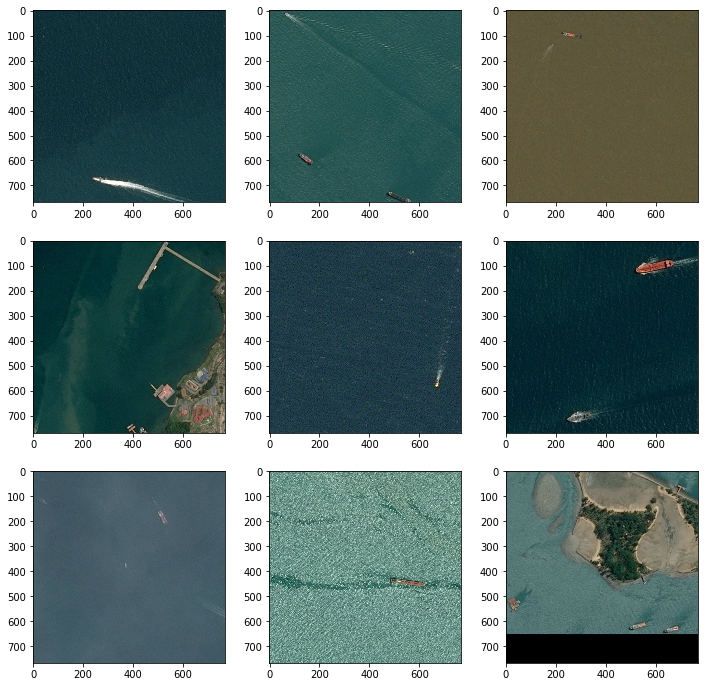

In [86]:
import skimage

np.random.seed(5)
file_names = np.random.choice(os.listdir("validation_images/"), 9)
fig, axes = plt.subplots(3,3, figsize=(12,12))
ax = axes.ravel()
for i, file_name in enumerate(file_names):
    img = skimage.io.imread("validation_images/"+file_name)
    ax[i].imshow(img)

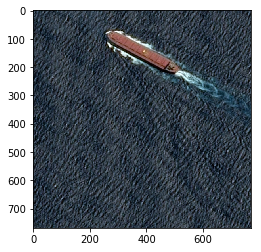

In [64]:
import skimage

# file_name = "validation_images/0190215b2.jpg"
file_name = "validation_images/0540b9975.jpg"
img = skimage.io.imread(file_name)
plt.imshow(img)

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

In [66]:
import json

object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b)
detections = json.loads(results)
# print (detections)

In [101]:
def visualize_detection(img_file, dets, ax, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        ax.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=1.5)
            ax.add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
#             ax.text(xmin, ymin - 2,
#                             '{:s} {:.3f}'.format(class_name, score),
#                             bbox=dict(facecolor=colors[cls_id], alpha=0.5),
#                                     fontsize=12, color='white')

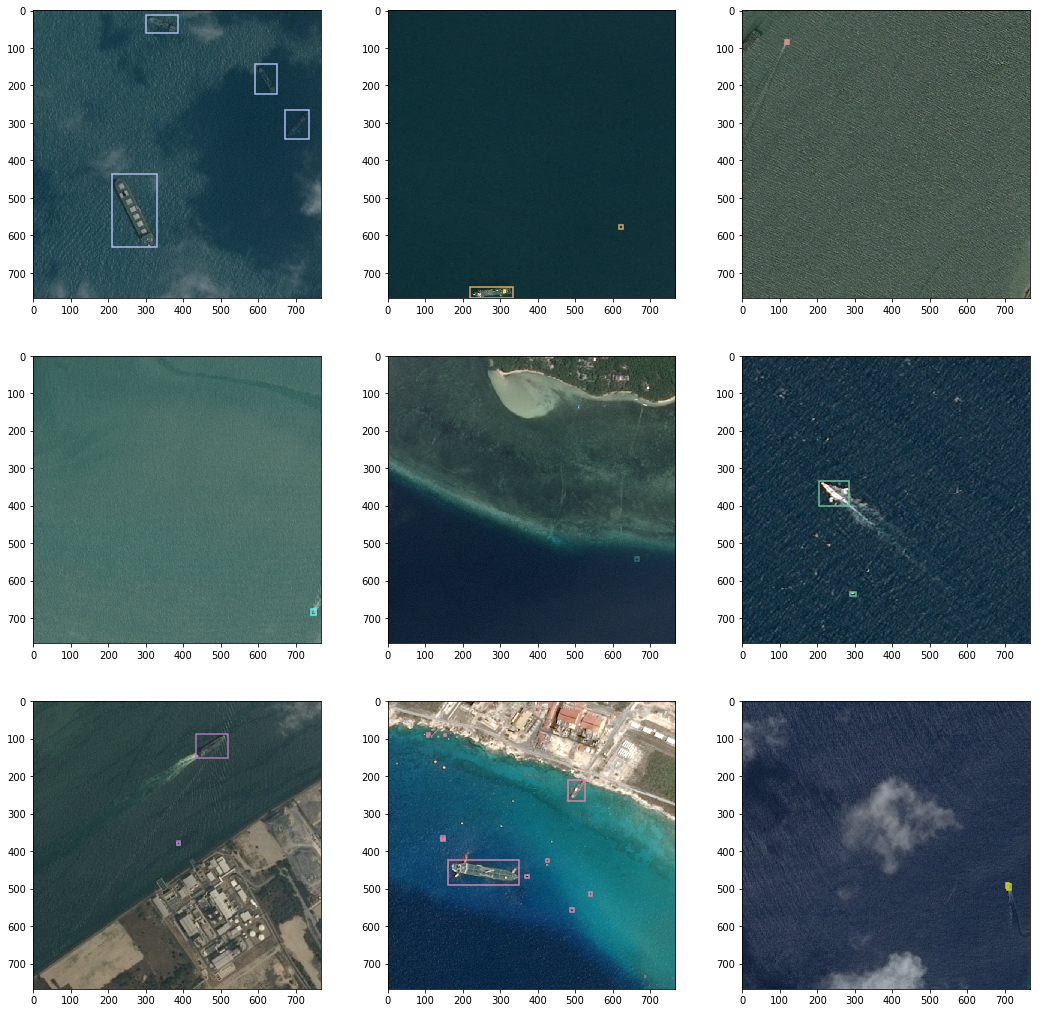

In [103]:
object_categories = ['ship']
# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.20

file_names = np.random.choice(os.listdir("validation_images/"), 9)
fig, axes = plt.subplots(3,3, figsize=(18,18))
ax = axes.ravel()

for i, file_name in enumerate(file_names):
    
    file_name = "validation_images/"+file_name
    
    with open(file_name, 'rb') as image:
        f = image.read()
        b = bytearray(f)
        ne = open('n.txt','wb')
        ne.write(b)
        
    object_detector.content_type = 'image/jpeg'
    results = object_detector.predict(b)
    detections = json.loads(results)

    # Visualize the detections.
    visualize_detection(file_name, detections['prediction'], ax[i], object_categories, threshold)

### Delete the Endpoint